# ChemCharts JSON Plot 

## PREPARATION 
Bevor using this notebook dependencies need to be loaded and paths updated.

In [3]:
# load dependencies
import os
import json
import tempfile
from IPython.display import Image

# change me
chemcharts_dir = os.path.expanduser("~/Documents/Projects/ChemCharts") # set project folder on your device
chemcharts_env = os.path.expanduser("~/miniconda3/envs/chemcharts")    # set environment path on your device
output_dir = os.path.expanduser("~/Desktop/chemcharts_json_test")      # set output path on your device

# do NOT change me
try: ipynb_path                                                   
except NameError: ipynb_path = os.getcwd()                             # sets root path

try:
    os.mkdir(output_dir)                                               # checks whether there is an output folder 
except FileExistsError:                                                # and generates one if there isn't one already available
    pass


## INITIALIZATION 
Continue with initializing a configuration dictionary.

In [4]:

conf={"chemcharts": {}}


### Header 
Add a header if needed.

In [5]:

conf={
  "chemcharts": {
    "header": {}                                                        # leave empty if not needed
  }
}


## EXECUTION
### Data loading
Now you can start adding tasks to the config file. Data loading is the obligatory first step.

In [6]:

conf["chemcharts"]["execution"] = [
      {"task":  "data_loading",
       "input":  os.path.join(chemcharts_dir, "data/scaffold_memory.csv"),
       "input_type":  "csv",
       "columns":  {
                     "smiles_column": "SMILES",
                     "scores_column": "total_score",
                     "epochs_column": "Step"
                    }
      }]
    

### Generate fingerprints
Once the data is loaded, we need to translate the chemical strings (SMILES) into fingerprints. There are a couple of different options, here we will use MACCS.

In [7]:

conf["chemcharts"]["execution"].append(
      {"task":  "generate_fingerprints",
       "type":  "maccs",                                                # you can choose between standard, morgan and maccs
       "parameters":  {"useFeatures": True}                             # with the other two fingerprints there are no parameters
      })


### Dimensional reduction
Reduces the number of features in your dataset with an UMP algorithm.

In [8]:

conf["chemcharts"]["execution"].append(
      {"task":  "dimensional_reduction",
       "type": "UMAP",
       "parameters":  {}
      })


### Optional: Filtering
You can define a filter range to reduce the input to the data within the range.

In [9]:

conf["chemcharts"]["execution"].append(
      {"task":  "filtering_data",
       "type": "filtering",
       "parameters":  {"range_dim1": [-100, 100],                       # set range for UMAP_1
                       "range_dim2": [-100, 100]}                       # set range for UMAP_2
      })


### Optional: Clustering
You can further prepare the data by clustering it with KMeans

In [10]:

conf["chemcharts"]["execution"].append(
      {"task":  "clustering_data",
       "type": "KMmeans",
       "parameters":  {"k": 10}                                         # set the number of desired KMeans clusters
      })


### Optional: Binning
You might also want to bin the scores and return their median. Binned scores will then be plotted in a histogram plot.

In [11]:

conf["chemcharts"]["execution"].append(
      {"task":  "binning_scores",
       "type": "binning",
       "parameters":  {"num_bins": 4}                                    # set the number of desired bins
      })


### Write-Out
When using large data sets it is advisable to write out the updated data and use the thereby generated pkl file as input from now onwards (potentially very time saving).

In [12]:

# write-out of data into a pkl file
conf["chemcharts"]["execution"].append({
        "task": "write_out",
        "format": "pkl",
        "path": os.path.join(output_dir, "simple_plot_test.pkl")           # choose loaction for ".pkl" file
      })

# write-out of configuration file
conf_preprocess_JSON_path = os.path.join(output_dir, "chemcharts_preprocess_data.json")
with open(conf_preprocess_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)
    
    
#execution
!{chemcharts_env}/bin/python {chemcharts_dir}/chemcharts_json.py -conf {conf_preprocess_JSON_path}


Task data_loading completed.
Task generate_fingerprints completed.
Task dimensional_reduction completed.
Task filtering_data completed.
Task clustering_data completed.
Task binning_scores completed.
Task write_out completed.


## PLOT GENERATION
### Example: Hexagonal plot generation
Once the updated data is saved in a pkl file you can start generating various plots.

Task data_loading completed.
Task generate_plot completed.


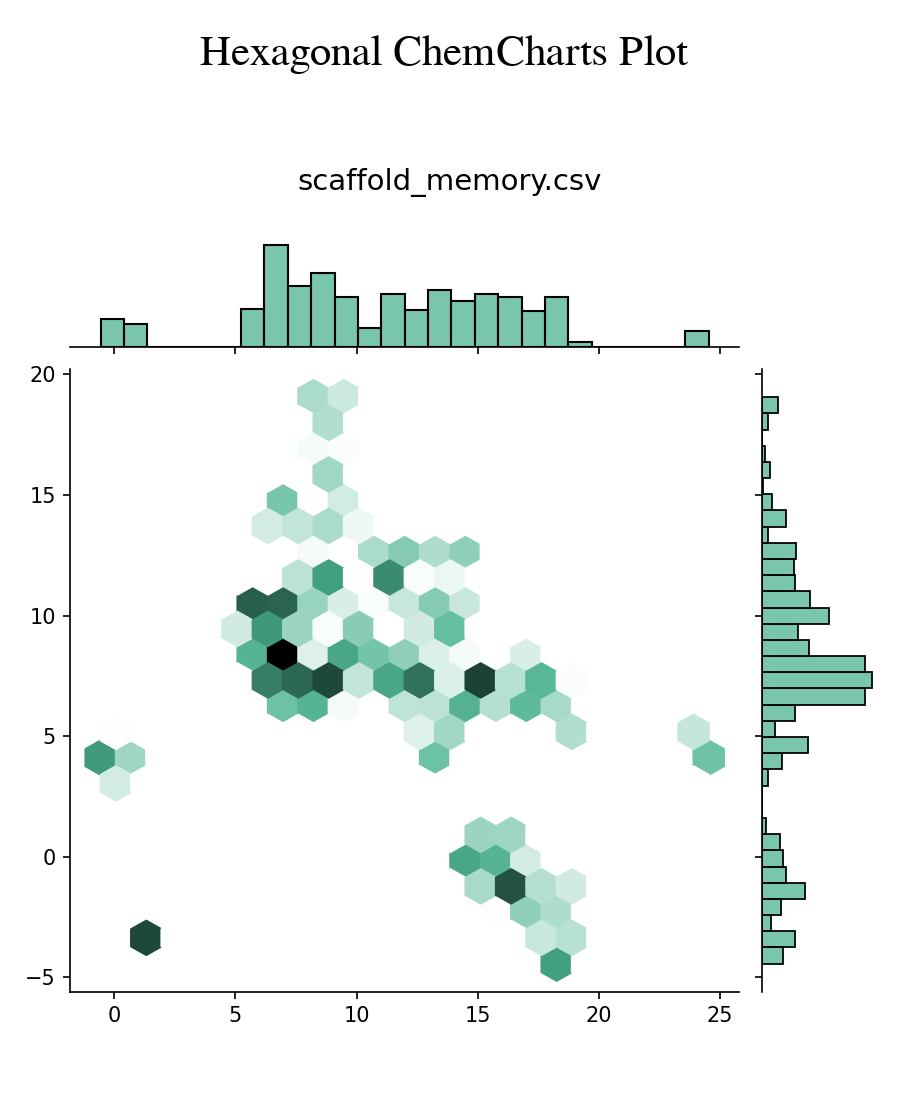

In [16]:

# now you can load the data from the pkl file and generate the plot
conf={
  "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(output_dir, "simple_plot_test.pkl")],
       "input_type":  "pkl"
      },
      {"task": "generate_plot",
       "type": "hexagonal_plot",                                             # choose plot type (here: Hexagonal)
       "parameters":  {"title": "Hexagonal ChemCharts Plot",                 # set plot title (default: Hexagonal Chemcharts Plot)
                       "gridsize": 20,                                       # set gridsize {default: 20}
                       "fontsize": 14,                                       # set fontsize of dataset title (default: 14) 
                       "top": 0.9,                                           # set top margin (default: 0.9)    
                       "color": "#4CB391"},                                  # set marker color (default: #4CB391)
        "settings": {"path": os.path.join(output_dir, "hexagonal_plot.png"), # set output path including file name
                     "format": "png",                                        # set file format (default: png)  
                     "dpi": 150}                                             # set dpi (default: 150)
      }
    ]
  }
}

# write-out of configuration file
configuration_JSON_path = os.path.join(output_dir, "chemcharts_config_plots.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True) 
    
#execution
!{chemcharts_env}/bin/python {chemcharts_dir}/chemcharts_json.py -conf {configuration_JSON_path}

# display plot 
Image(filename=os.path.join(output_dir, "hexagonal_plot.png"), width=400, height=200)      # with width and height you can alternate the displayed image size


### Example: Hexagonal plot generation with defined xlim and ylim
The parameters xlim and ylim allow to define an excerpt for the plot.

Task data_loading completed.
Task generate_plot completed.


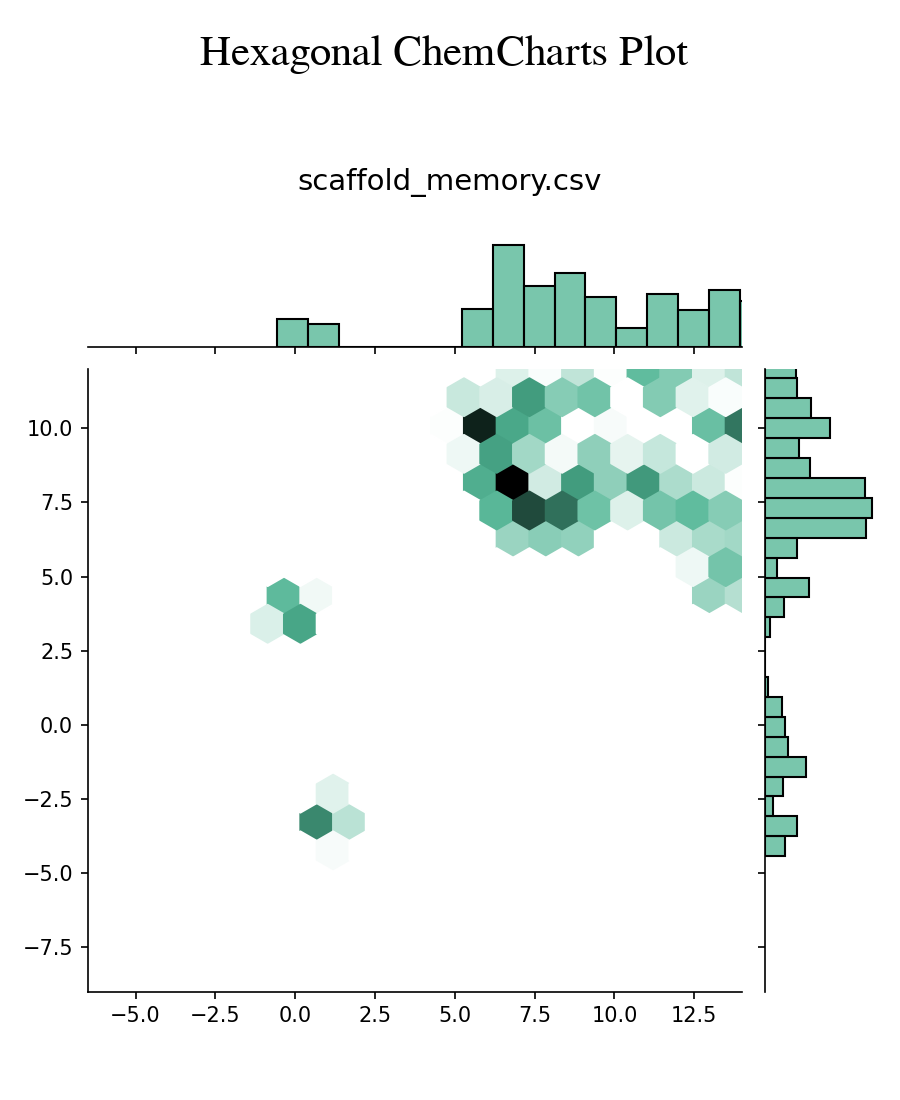

In [17]:

# plot generation with defined xlim and ylim
conf={
  "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(output_dir, "simple_plot_test.pkl")],
       "input_type":  "pkl"
      },
      {"task": "generate_plot",
       "type": "hexagonal_plot",                                             
       "parameters":  {"title": "Hexagonal ChemCharts Plot",                 
                       "gridsize": 20,                                       
                       "fontsize": 14,                                        
                       "top": 0.9,                                           
                       "xlim": [-6.5, 14],                                   # set xlim
                       "ylim": [-9, 12],                                     # set ylim   
                       "color": "#4CB391"},                                  
        "settings": {"path": os.path.join(output_dir, "hexagonal_xlim_ylim_plot.png"), 
                     "format": "png",                                          
                     "dpi": 150}                                             
      }
    ]
  }
}

# write-out of configuration file
configuration_JSON_path = os.path.join(output_dir, "chemcharts_config_plots.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)
    
#execution
!{chemcharts_env}/bin/python {chemcharts_dir}/chemcharts_json.py -conf {configuration_JSON_path}


# display plot
Image(filename=os.path.join(output_dir, "hexagonal_xlim_ylim_plot.png"), width=400, height=200)      # with width and height you can alternate the displayed image size


### Example: Multiple plot generation
You can also generate multiple plots at once.

Task data_loading completed.
Task generate_plot completed.
Task generate_plot completed.


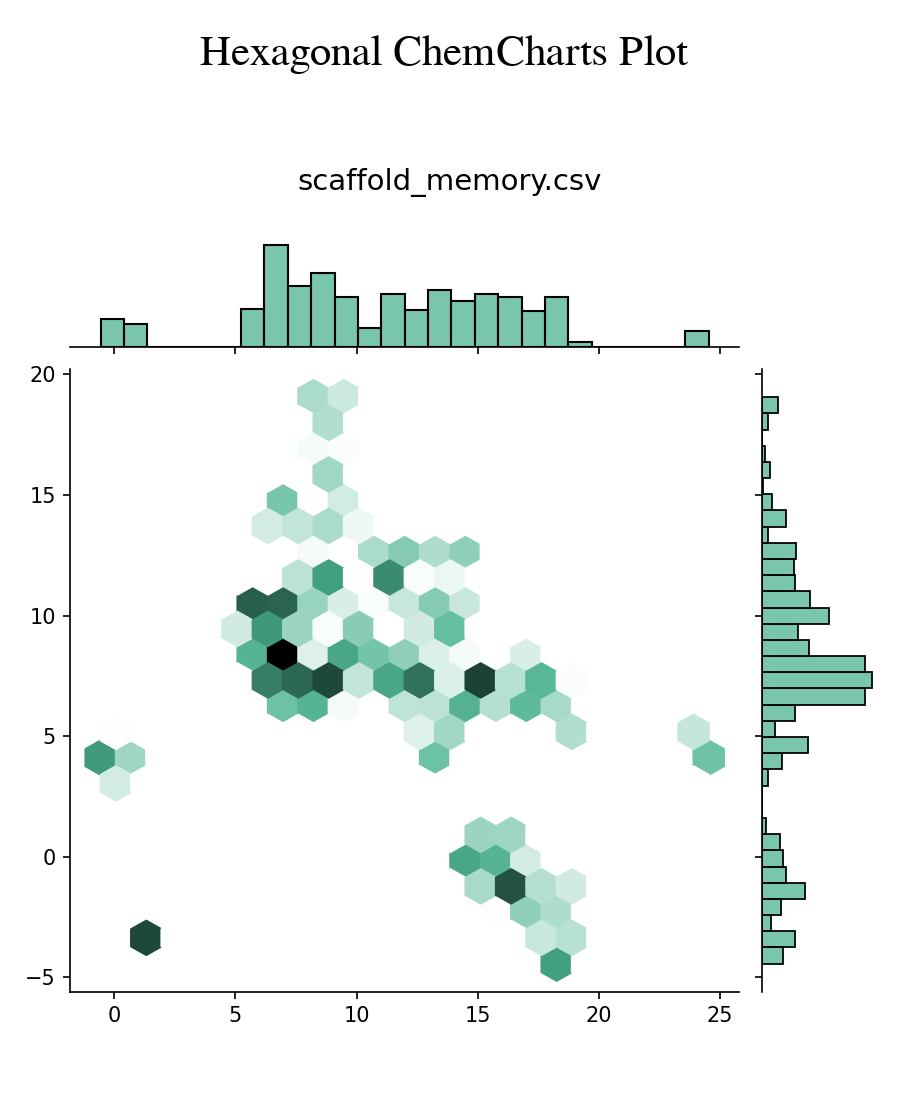

In [18]:

# generates a hexagonal and histogram plot
conf={
  "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(output_dir, "simple_plot_test.pkl")],
       "input_type":  "pkl"
      },
      {"task": "generate_plot",
       "type": "hexagonal_plot",
       "parameters":  {"title": "Hexagonal ChemCharts Plot",
                       "gridsize": 20,
                       "fontsize": 14,
                       "top": 0.9,
                       "color": "#4CB391"},
        "settings": {"path": os.path.join(output_dir, "hexagonal_plot.png"),
                     "format": "png",
                     "dpi": 150}
      },
      {"task": "generate_plot",
       "type": "histogram_plot",                                              # choose plot type (here: Histogram)
       "parameters":  {"title": "Histogram ChemCharts Plot",                  # set plot title (default: Histogram Chemcharts Plot)
                       "bins": 20,                                            # set bin number {default: 20}
                       "fontsize": 14,                                        # set fontsize of dataset title (default: 14) 
                       "top": 0.9,                                            # set top margin (default: 0.9)
                       "color": "#d11d80"},                                   # set marker color (default: #d11d80)
       "settings": {"path": os.path.join(output_dir, "histogram_plot.png"),   # set output path including file name
                    "format": "png",                                          # set file format (default: png)  
                    "dpi": 300,                                               # set dpi (default: 300)
                    "figsize": [1, 1]}                                      # set figuresize (default: [17, 17])
      }
    ]
  }
}

# write-out of configuration file
configuration_JSON_path = os.path.join(output_dir, "chemcharts_config_plots.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)
    
#execution
!{chemcharts_env}/bin/python {chemcharts_dir}/chemcharts_json.py -conf {configuration_JSON_path}

# display hexagonal plot
Image(filename=os.path.join(output_dir, "hexagonal_plot.png"), width=400, height=200)      # with width and height you can alternate the displayed image size     


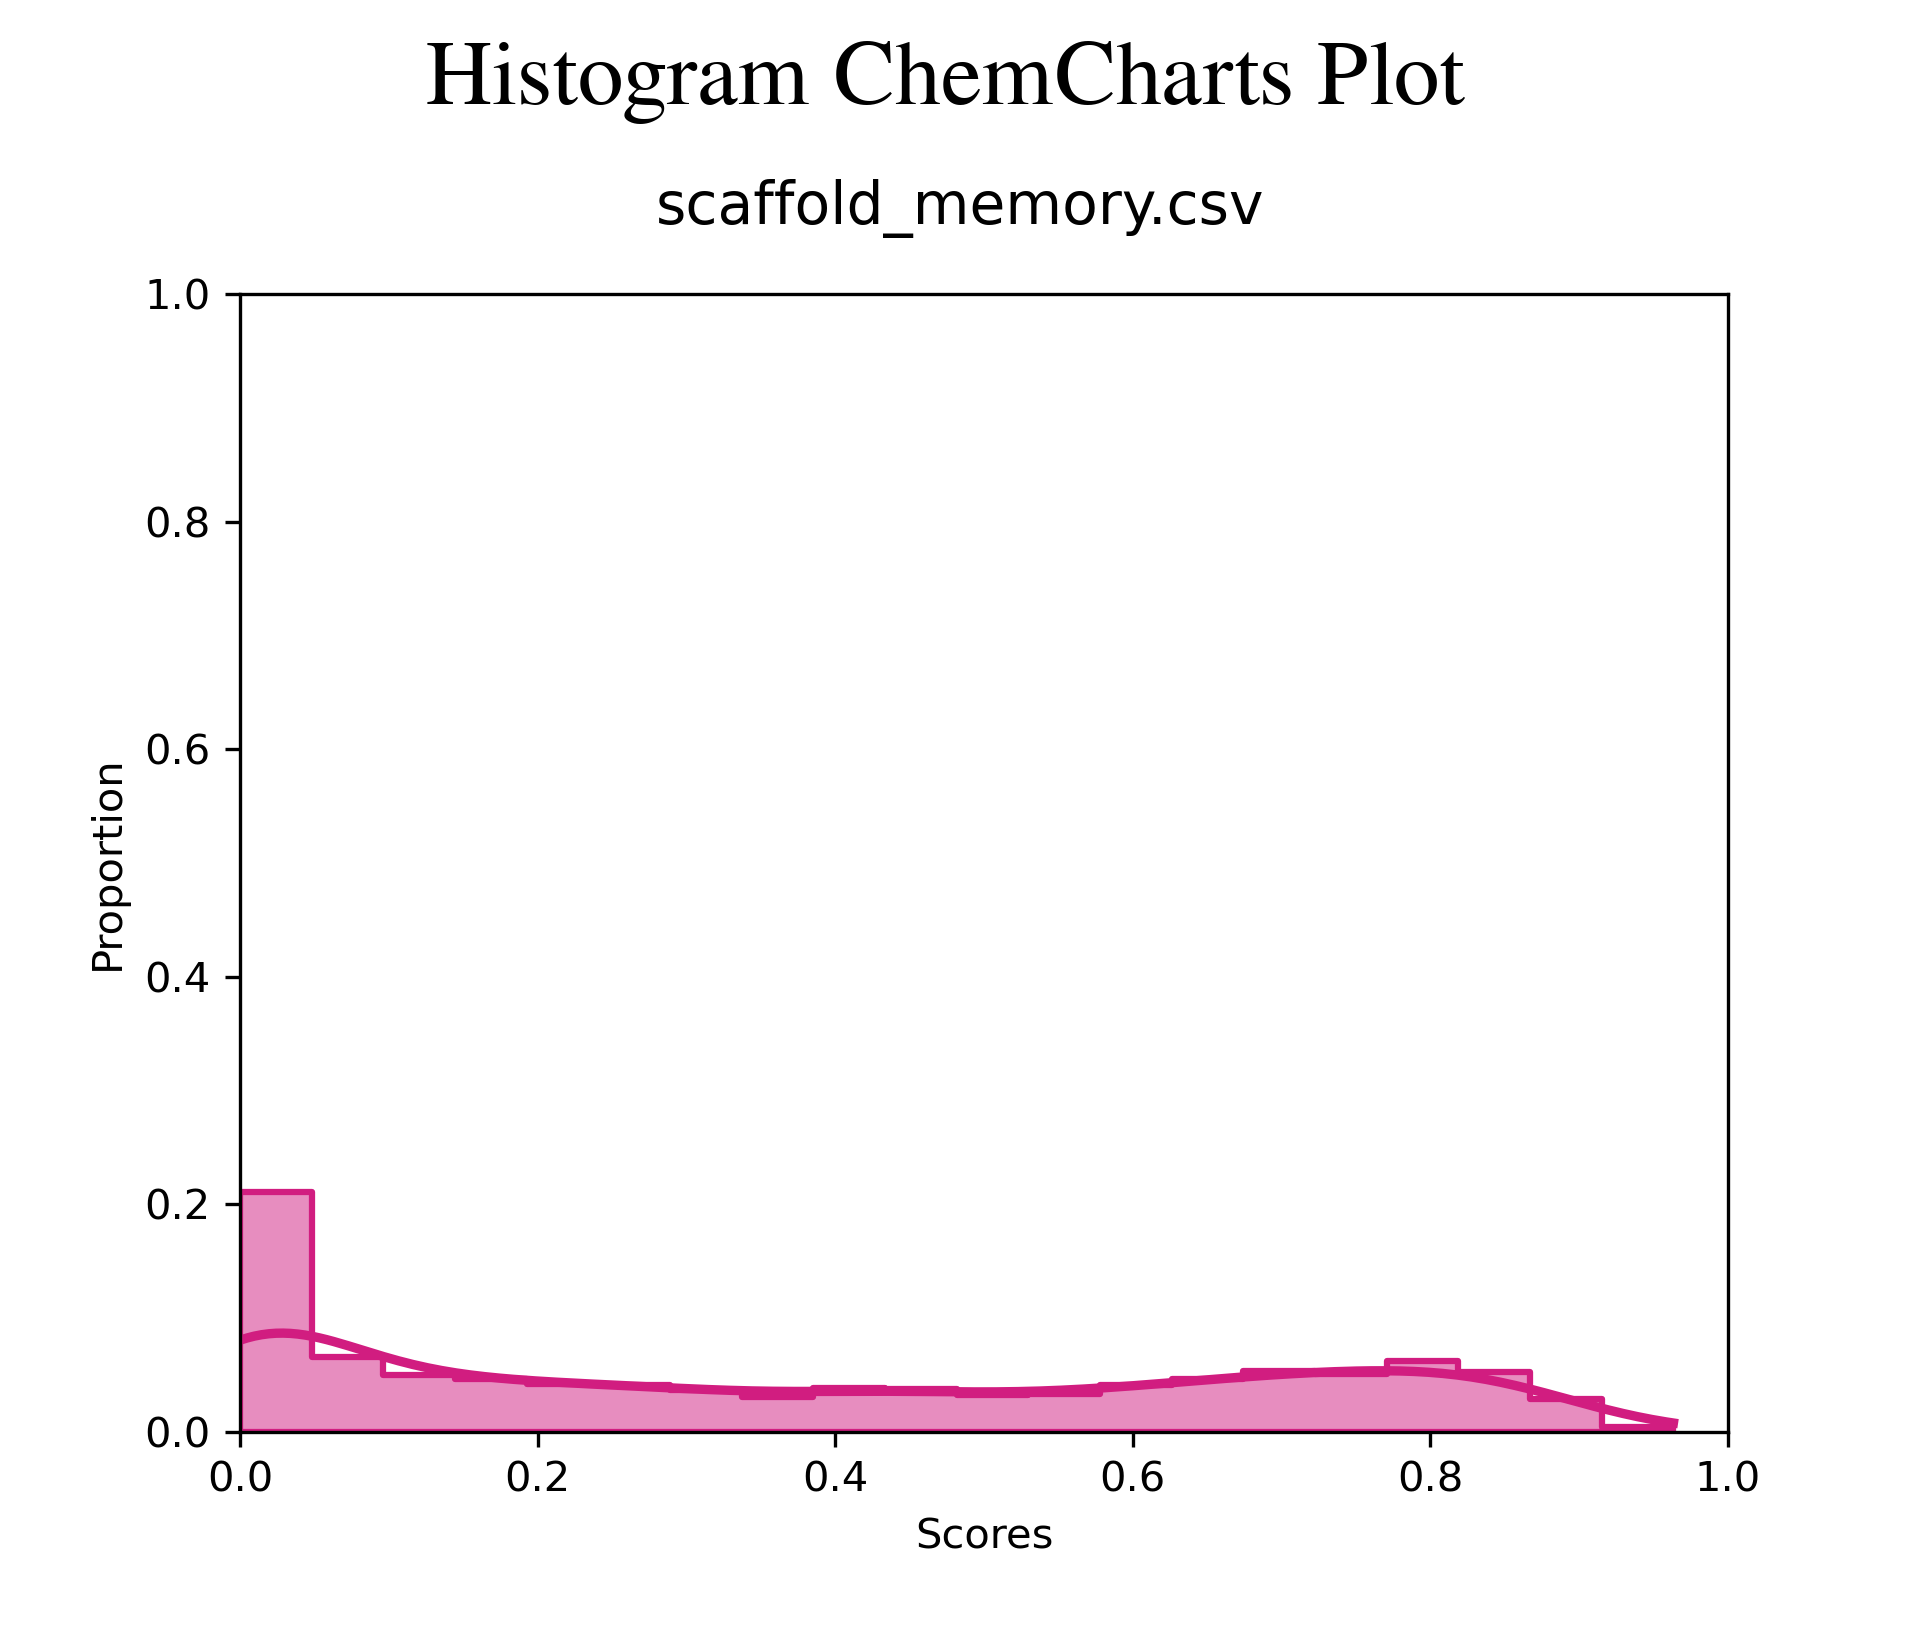

In [20]:

# display histogram plot
Image(filename=os.path.join(output_dir, "histogram_plot.png"), width=400, height=200) 


## PLOT VARIANTS
ChemCharts can generate multiple plot variants: 

In [ ]:
 
    # Scatter Boxplot

     {"task": "generate_plot",
       "type": "scatter_boxplot_plot",
       "parameters":  {"title": "Scatter Boxplot ChemCharts Plot",                   # set plot title (default: Scatter Boxplot Chemcharts Plot)
                       "fontsize": 14,                                               # set fontsize of dataset title (default: 14) 
                       "top": 0.9},                                                  # set top margin (default: 0.9)
        "settings": {"path": os.path.join(output_dir, "scatter_boxplot_plot.png"),   # set output path including file name
                     "format": "png",                                                # set file format (default: png) 
                     "dpi": 150,                                                     # set dpi (default: 150)
                     "figsize": [17, 17]}                                            # set figuresize (default: [17, 17])
      }
    
    
    # Scatter Interactive
    
      {"task": "generate_plot",
       "type": "scatter_interactive_plot",
       "parameters":  {"title": "Scatter Interactive ChemCharts Plot",                # set plot title (default: Scatter Interactive Chemcharts Plot)
                       "marker_size": 1},                                             # set marker size (default: 1)
       "settings": {"path": os.path.join(output_dir, "scatter_interactive_plot.png"), # set output path including file name
                    "view": True,                                                    # set view on true if pop-up window is desired (default: false)
                    "format": "png"}                                                 # set file format (default: png) 
      }
        
    # Scatter Static
    
      {"task": "generate_plot",
       "type": "scatter_static_plot",
       "parameters":  {"title": "Scatter Static ChemCharts Plot",                     # set plot title (default: Scatter Static Chemcharts Plot)
                       "color": "#0000ff",                                            # set marker color (default: #0000ff)
                       "s": 1},                                                       # set marker size (default: 6)
        "settings": {"path": os.path.join(output_dir, "scatter_static_plot.png"),     # set output path including file name
                     "format": "png",                                                 # set file format (default: png) 
                     "dpi": 150,                                                      # set dpi (default: 150)
                     "figsize": [17, 17]}                                             # set figuresize (default: [17, 17])
      }
    
    
    # Trisurf Interactive
    
      {"task": "generate_plot",
       "type": "trisurf_interactive_plot",
       "parameters":  {"title": "Trisurf Interactive ChemCharts Plot",                 # set plot title (default: Trisurf Interactive Chemcharts Plot)
                       "color": "Portland"},                                           # set plotly built-in continuous color scales (default: Portland)
       "settings": {"path": os.path.join(output_dir, "trisurf_interactive_plot.png"),  # set output path including file name
                    "view": True,                                                      # set view on true if pop-up window is desired (default: false)
                     "format": "png"}                                                  # set file format (default: png) 
      }
       
        
    # Trisurf Static
    
      {"task": "generate_plot",
       "type": "trisurf_static_plot",
       "parameters":  {"title": "Trisurf Static ChemCharts Plot",                       # set plot title (default: Trisurf Static Chemcharts Plot)
                       "color": "gist_rainbow"},                                        # set matplotlib colormap (default: gist_rainbow)
        "settings": {"path": os.path.join(output_dir, "trisurf_static_plot.png"),       # set output path including file name
                     "format": "png",                                                   # set file format (default: png) 
                     "dpi": 150,                                                        # set dpi (default: 150)
                     "figsize": [9, 9]}                                                 # set figuresize (default: [9, 9])
      }
    